# k-Nearest Neighbor (kNN) implementation

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In [1]:
'''
If you are using Google Colab, uncomment the next line to download `k_nearest_neighbor.py`. 
'''
!wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/assignment0_01_kNN/k_nearest_neighbor.py

--2020-02-16 12:39:16--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/assignment0_01_kNN/k_nearest_neighbor.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.112.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 8278 (8,1K) [text/plain]
Сохранение в: «k_nearest_neighbor.py.1»

k_nearest_neighbor. 100%[===================>]   8,08K  --.-KB/s    за 0s      

2020-02-16 12:39:17 (81,4 MB/s) - «k_nearest_neighbor.py.1» сохранён [8278/8278]



In [2]:
from sklearn import datasets
dataset = datasets.load_digits()
print(dataset.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
# First 100 images will be used for testing. This dataset is not sorted by the labels.
test_border = 100
X_train, y_train = dataset.data[test_border:], dataset.target[test_border:]
X_test, y_test = dataset.data[:test_border], dataset.target[:test_border]

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
num_test = X_test.shape[0]

Training data shape:  (1697, 64)
Training labels shape:  (1697,)
Test data shape:  (100, 64)
Test labels shape:  (100,)


In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


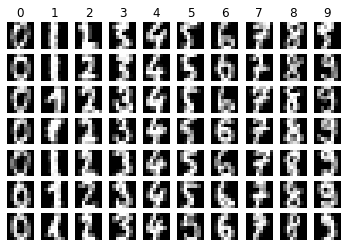

In [5]:
# Visualize some examples from the dataset.
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((8, 8)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
try:
    del KNearestNeighbor
except:
    pass

from k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance.  
classifier = KNearestNeighbor()
classifier.fit(X_train, y_train)

In [7]:
X_train.shape

(1697, 64)

We would now like to classify the test data with the kNN classifier. We can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. 

In [8]:
# Test implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(100, 1697)


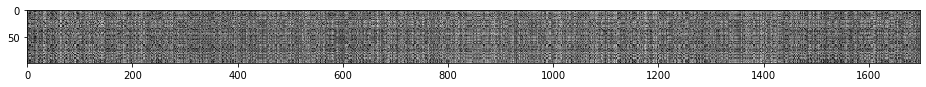

In [9]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.figure(figsize=(16, 9))
plt.imshow(dists, interpolation='none')
plt.show()

In [10]:
# Now run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 95 / 100 correct => accuracy: 0.950000


We can see approximately `95%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [11]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 93 / 100 correct => accuracy: 0.930000


Accuracy slightly decrease with `k = 5` compared to `k = 1`.

In [12]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop.
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. To do this, use the Frobenius norm.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Now implement the fully vectorized version
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


### Comparing handcrafted and `sklearn` implementations
In this section we will just compare the performance of handcrafted and `sklearn` kNN algorithms. The predictions should be the same.

In [14]:
from sklearn import neighbors

In [15]:
implemented_knn = KNearestNeighbor()
implemented_knn.fit(X_train, y_train)

In [16]:
n_neighbors = 1
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn kNN (k=1) implementation achieves: {} accuracy on the test set'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Handcrafted kNN (k=1) implementation achieves: {} accuracy on the test set'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Labels predicted by handcrafted and sklearn kNN implementations are different!'
print('\nsklearn and handcrafted kNN implementations provide same predictions')
print('_'*76)


n_neighbors = 5
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn kNN (k=5) implementation achieves: {} accuracy on the test set'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Handcrafted kNN (k=5) implementation achieves: {} accuracy on the test set'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Labels predicted by handcrafted and sklearn kNN implementations are different!'
print('\nsklearn and handcrafted kNN implementations provide same predictions')
print('_'*76)



sklearn kNN (k=1) implementation achieves: 0.95 accuracy on the test set
Handcrafted kNN (k=1) implementation achieves: 0.95 accuracy on the test set

sklearn and handcrafted kNN implementations provide same predictions
____________________________________________________________________________
sklearn kNN (k=5) implementation achieves: 0.93 accuracy on the test set
Handcrafted kNN (k=5) implementation achieves: 0.93 accuracy on the test set

sklearn and handcrafted kNN implementations provide same predictions
____________________________________________________________________________


### Measuring the time
Finally let's compare how fast the implementations are.

To make the difference more noticable, let's repeat the train and test objects (there is no point but to compute the distance between more pairs).

In [17]:
X_train_big = np.vstack([X_train]*5)
X_test_big = np.vstack([X_test]*5)
y_train_big = np.hstack([y_train]*5)
y_test_big = np.hstack([y_test]*5)

In [18]:
classifier_big = KNearestNeighbor()
classifier_big.fit(X_train_big, y_train_big)

def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier_big.compute_distances_two_loops, X_test_big)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier_big.compute_distances_one_loop, X_test_big)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier_big.compute_distances_no_loops, X_test_big)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 19.973965 seconds
One loop version took 0.561699 seconds
No loop version took 0.056771 seconds


The improvement seems significant. We have received a multiple reduction in operating time.